In [1]:
%load_ext autoreload
%autoreload 2
import glob
import matplotlib.pyplot as plt
from matplotlib import cycler
import datetime
import pandas as pd
import os
import helper
import numpy as np
import seaborn as sns
import itertools
import json
from scipy import stats

import helper

In [2]:

cycler_colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#CF4457', '#188487', '#E24A33']
def set_matplot_params(font_size = 8, xtick_major = 0.25, xtick_minor = 0.25, ytick_major = 0.25, ytick_minor = 0.25):
    params_dict = {
        'text.usetex': False,
        # 'font.family': 'Times New Roman',
        # 'font.serif': 'Times New Roman',
        # 'font.sans-serif': 'Times New Roman',
        'font.size': font_size,
        'figure.figsize': [3.125, 1.93],  # Golden ratio
        #figure.figsize: 3.125, 1.56  # Squash for more space
        'legend.fontsize': 6,
        'legend.fancybox': False,
        'axes.linewidth': 0.5,
        'pdf.fonttype' : 42,
        'ps.fonttype' : 42,
        'axes.prop_cycle': cycler("color", cycler_colors),
                          # 348ABD : blue
                          # A60628 : red
                          # 7A68A6 : purple
                          # 467821 : green
                          # CF4457 : pink
                          # 188487 : turquoise
                          # E24A33 : orange
        'patch.linewidth': 0.5,
        'lines.linewidth': 2,
        'grid.linewidth': 0.1,
        'xtick.major.width': xtick_major,
        'xtick.minor.width': xtick_minor,
        'ytick.major.width': ytick_major,
        'ytick.minor.width': ytick_minor,
        'legend.numpoints': 1}
    plt.rcParams.update(params_dict)
set_matplot_params()

In [3]:
import os

def loop_through_csv_files(root_dir):
    data = {}
    # Loop through the time folders (15 and 60)
    for time_folder in os.listdir(root_dir):
        time_folder_path = os.path.join(root_dir, time_folder)
        
        # Loop through the location folders (satellite and campus)
        for location_folder in os.listdir(time_folder_path):
            location_folder_path = os.path.join(time_folder_path, location_folder)
            
            # Loop through the rate folders (3Mbps and 5Mbps)
            for rate_folder in os.listdir(location_folder_path):
                rate_folder_path = os.path.join(location_folder_path, rate_folder)
                
                # Loop through the experiment folders (1, 2, 3, 4, 5)
                for experiment_folder in os.listdir(rate_folder_path):
                    experiment_folder_path = os.path.join(rate_folder_path, experiment_folder)
                    
                    # Check if the experiment folder contains a QoE folder
                    qoe_folder_path = os.path.join(experiment_folder_path, 'QoE')
                    if os.path.isdir(qoe_folder_path):
                        
                        # Loop through the CSV files in the QoE folder
                        file_data = []
                        for file in os.listdir(qoe_folder_path):
                            file_path = os.path.join(qoe_folder_path, file)
                            
                            # Check if the file is a CSV file
                            if file.endswith('.csv'):
                                file_data.append(file_path)
                        
                        data[rate_folder_path] = file_data
        
    return data

# Usage example
root_dir = 'dataset'
data_links = loop_through_csv_files(root_dir)


In [4]:
import pandas as pd

def tally_state(rah, column):
    alltally = {}
    for key, file_paths in rah.items():
        total_tally = 0
        tally = {}
        for i in range(0,5):    
            tally[i] = 0
        for file_path in file_paths:
            df = pd.read_csv(file_path)
            if column in df.columns:
                ready_state_counts = df[column].value_counts()
                
                for ready_state, count in ready_state_counts.items():
                    tally[ready_state] += count
                    total_tally += count   
        alltally[key] = [tally[0] / total_tally, tally[1] / total_tally, tally[2] / total_tally, tally[3] / total_tally, tally[4] / total_tally]

    return alltally

def chart_tally(tally, column):
    for key, total_tally in tally.items():
        dataset, time, location, rate = key.split('/')
        labels = ['0', '1', '2', '3', '4']
        percentages = [round(val * 100, 2) for val in total_tally]
        
        plt.bar(labels, percentages)
        plt.xlabel(column)
        plt.ylabel('Percentage')
        plt.title(f'readyState using {location} network at {rate} for {time} seconds')
        plt.show()
# Usage example




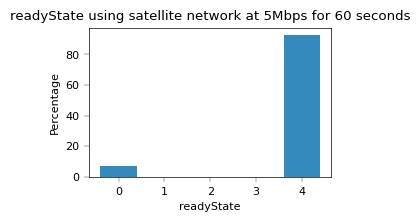

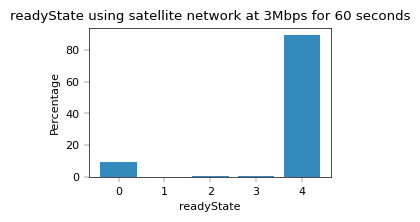

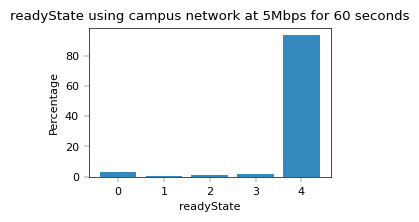

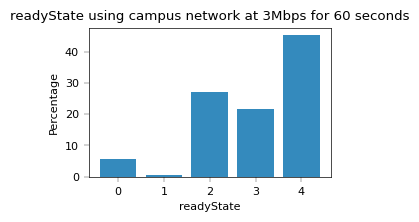

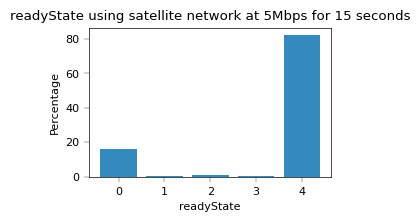

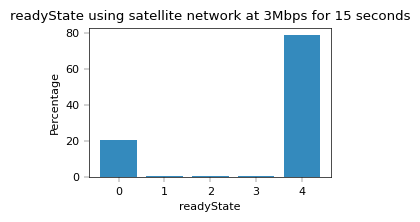

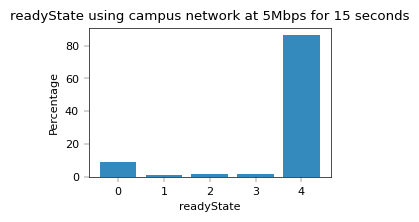

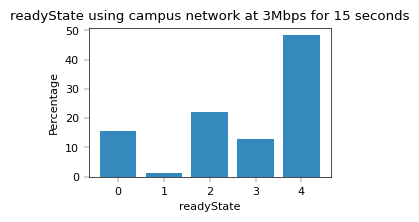

In [5]:
readyStateTally = tally_state(data_links, 'readyState')
chart_tally(readyStateTally, 'readyState')


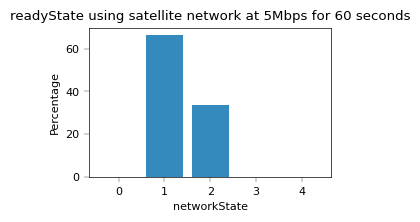

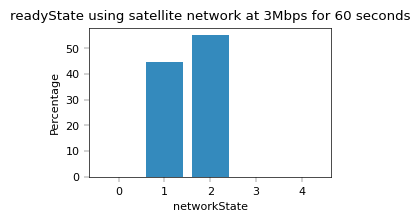

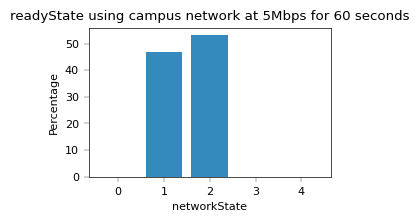

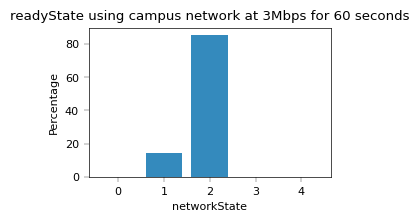

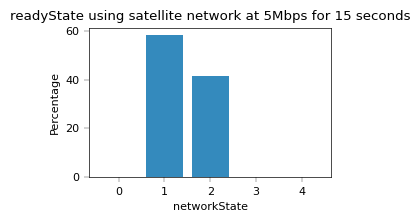

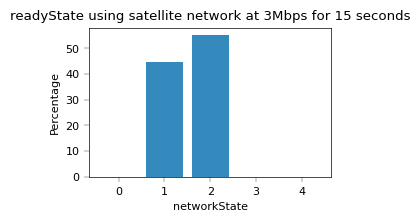

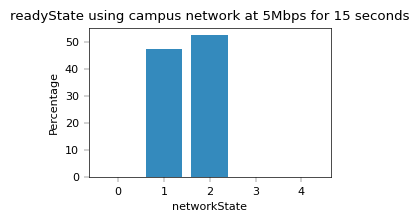

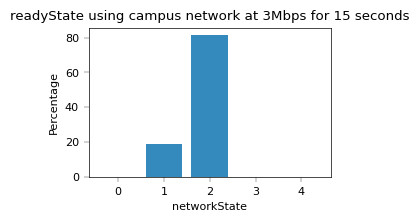

In [6]:
networkStateTally = tally_state(data_links, 'networkState')
chart_tally(networkStateTally, 'networkState')

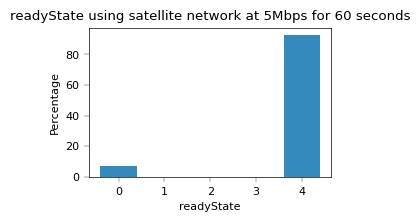

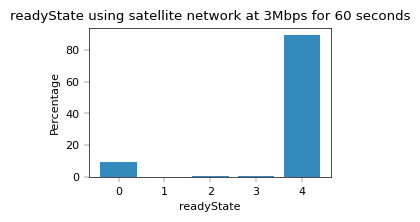

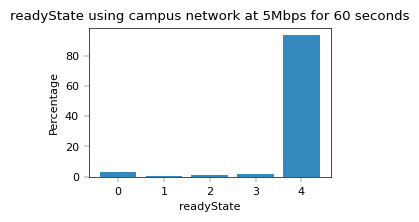

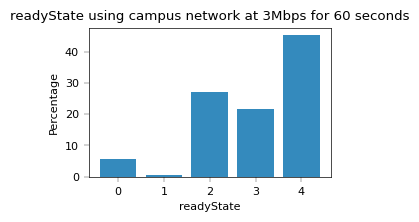

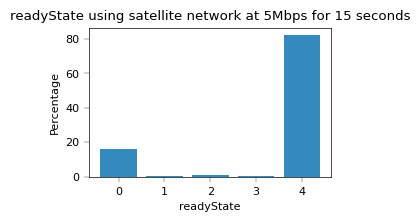

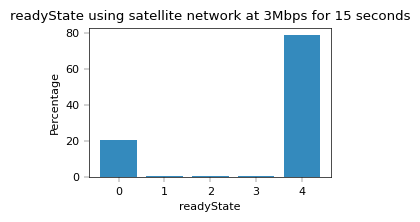

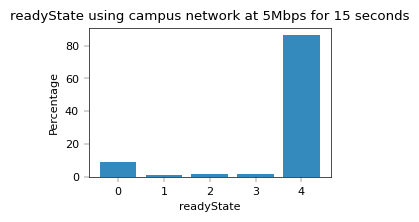

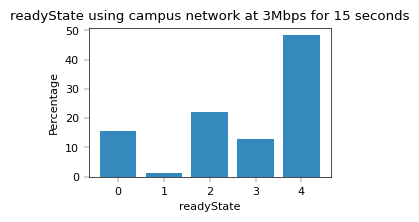

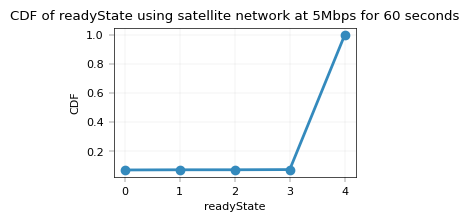

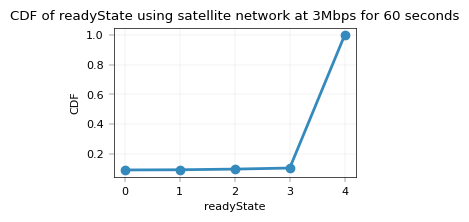

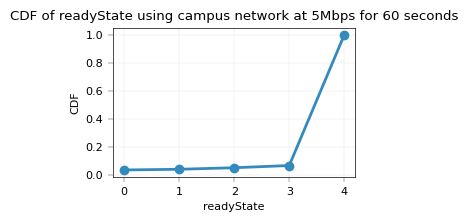

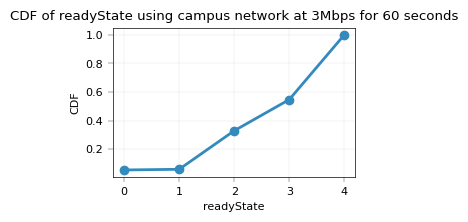

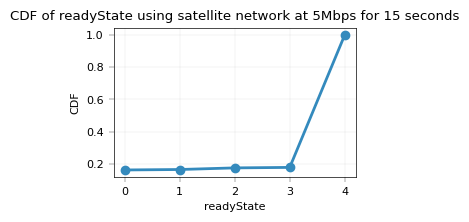

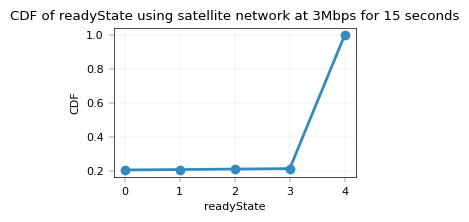

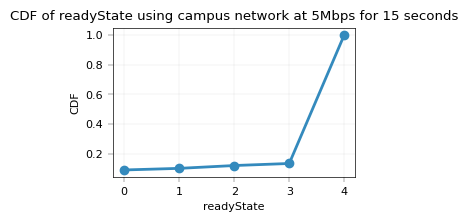

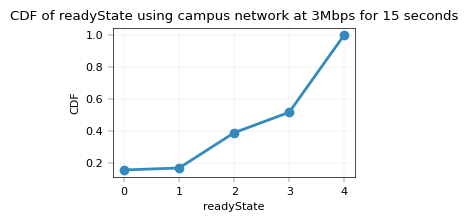

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def tally_state(rah, column):
    alltally = {}
    for key, file_paths in rah.items():
        total_tally = 0
        tally = {i: 0 for i in range(5)}
        for file_path in file_paths:
            df = pd.read_csv(file_path)
            if column in df.columns:
                ready_state_counts = df[column].value_counts()
                for ready_state, count in ready_state_counts.items():
                    tally[ready_state] += count
                    total_tally += count
        alltally[key] = {i: tally[i] / total_tally for i in range(5)}
    return alltally

def chart_tally(tally, column):
    for key, total_tally in tally.items():
        dataset, time, location, rate = key.split('/')
        labels = ['0', '1', '2', '3', '4']
        percentages = [round(val * 100, 2) for val in total_tally.values()]

        plt.bar(labels, percentages)
        plt.xlabel(column)
        plt.ylabel('Percentage')
        plt.title(f'readyState using {location} network at {rate} for {time} seconds')
        plt.show()

def chart_cdf(tally, column):
    for key, total_tally in tally.items():
        dataset, time, location, rate = key.split('/')
        labels = ['0', '1', '2', '3', '4']
        percentages = [total_tally[i] for i in range(5)]

        # Calculate cumulative distribution
        cdf = [sum(percentages[:i+1]) for i in range(5)]

        plt.plot(labels, cdf, marker='o')
        plt.xlabel(column)
        plt.ylabel('CDF')
        plt.title(f'CDF of readyState using {location} network at {rate} for {time} seconds')
        plt.grid(True)
        plt.show()

column = 'readyState'
tally = tally_state(data_links, column)
chart_tally(tally, column)
chart_cdf(tally, column)
